In [1]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, inv
import numpy as np
from tqdm import tqdm
import matplotlib.gridspec as gridspec

In [12]:
import matplotlib as mpl

mpl.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 24,                # Default font size
    'axes.labelsize': 24,           # Axis label font size
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'lines.linewidth': 3,
    'lines.markersize': 8,
    'legend.frameon': False,
    'text.usetex': False            # Set to True if using LaTeX
})

Convergence % (move legend outside?)
Spec2, random, heavy tail

+random more iterations
+heavy cauchy

Plot number of iterations until convergence (examples where it does converge) (spec2 only)
x-axis: sample size, y-axis: iter until convergence (log scale) 

Convergence time plots
Figure 1: Theoretical (spec2 and random)
Figure 2: Faster less stable methods (spec2 and random)
Figure 3: Heavy tailed (3 methods under spec2)  - Not necessary


+Geometric mean
+random more iterations

+Slice at max sample size (show superlinear)




Algorithms

In [3]:
# Take minimum error for all positive and negative x
def min_error(x_hat, x_star):
    errors = []
    for x in x_hat:
            error_positive = np.linalg.norm(x_star - x)
            error_negative = np.linalg.norm(-x_star - x)
            errors.append(min(error_positive, error_negative))
    return errors

In [ ]:
def bwgd(y, A, niter=60, init="spec2"):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

    # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/2 - np.exp(-y / lambda_sq)) ) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
        x[0] = C_inv @ x_tilde
   
    elif init=="rand":
         x_tilde= np.random.randn(d)
         x[0] = C_inv @ x_tilde
           
    for iter in range(1, niter):
        hessian = (A_tilde @ A_tilde.T) / n
        
        # Gradient
        At_x = A_tilde.T @ x_tilde  
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y) * At_x / (np.abs(At_x)*n))
        x_tilde -= np.linalg.solve(hessian, gradient)

        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-10:
            return x[:iter], iter

    return x, iter

In [52]:
def bwgd_smooth(y, A, niter=60, gamma=0.01, init="spec2"):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

     # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y**2)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/np.sqrt(3) - np.exp(-y**2 / lambda_sq)) ) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
        x[0] = C_inv @ x_tilde

    elif init=="rand":
         x_tilde= np.random.randn(d)
         x[0] = C_inv @ x_tilde


    for iter in range(1, niter):
        loss_values = (np.abs(A_tilde.T @ x_tilde) - y) ** 2
        epsilon = np.quantile(loss_values, gamma)

        # Compute values
        row_norms = np.sum(A_tilde**2, axis=0)
        numerator = np.sqrt(y**2 + epsilon * row_norms)
        denominator = np.sqrt(np.sum(A_tilde * ((np.outer(x_tilde,x_tilde) + epsilon * np.eye(d)) @ A_tilde), axis=0))
        alpha = numerator / denominator 

        # Update rule in matrix form
        x_tilde = (1/n) * A_tilde @ (alpha * (A_tilde.T @ x_tilde))
        
        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-10:
            return x[:iter], iter

    return x, iter

In [297]:
def bwgd_smooth_loss(y, A, niter=3000, init="spec2"):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

     # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y**2)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/np.sqrt(3) - np.exp(-y**2 / lambda_sq)) ) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
        x[0] = C_inv @ x_tilde

    elif init=="rand":
         x_tilde= np.random.randn(d)
         x[0] = C_inv @ x_tilde


    for iter in range(1, niter):
        loss_values = np.mean((np.abs(A_tilde.T @ x_tilde) - y) ** 2)
        epsilon = loss_values**(1/4)

        # step size
        step = 1/(1 + epsilon)
        
        # Compute values
        row_norms = np.sum(A_tilde**2, axis=0)
        numerator = np.sqrt(y**2 + epsilon * row_norms)
        denominator = np.sqrt(np.sum(A_tilde * ((np.outer(x_tilde,x_tilde) + epsilon * np.eye(d)) @ A_tilde), axis=0))
        alpha = numerator / denominator 

        # Update rule in matrix form
        x_tilde = (1 - step) * x_tilde + step * (1/n) * A_tilde @ (alpha * (A_tilde.T @ x_tilde))
        
        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-10:
            return x[:iter], iter

    return x, iter

Convergence % (move legend outside?)
Spec2, random, heavy tail

In [174]:
# % of Convergence for higher samples, keeping d=200. Compares smooth and not smooth bwgd with the 2nd spectral initialization
def convergence_percent(init, ns, niter=100, trials=200, heavy_tail=False):
    d = 200
    conv_regular = []
    conv_smooth = []
    conv_smoothl = []
    
    for n in tqdm(ns):
        n=int(n)
        # Plot 
        conv_regular_number = 0
        conv_smooth_number = 0
        conv_smoothl_number = 0
        for j in range(trials):  
            # Generate vectors
            x = np.ones(d)/np.sqrt(d)
            if heavy_tail:
                A = np.random.standard_t(5, (d, n))
                A = np.random.standard_cauchy((d, n))
            else:
                A = np.random.randn(d, n)
            y1 = np.square(A.T @ x)
            y2 = np.abs(A.T @ x)
                
            # Run the algorithm
            x_hat1, iters1 = bwgd(y1, A, init=init, niter=niter)
            x_hat2, iters2 = bwgd_smooth(y2, A, init=init, niter=niter)
            x_hat3, iters3 = bwgd_smooth_loss(y2, A, init=init, niter=3000)
    
            if min_error(x_hat1, x)[-1]<1e-9:
                conv_regular_number += 1
            if min_error(x_hat2, x)[-1]<1e-9:
                conv_smooth_number += 1
            if min_error(x_hat3, x)[-1]<1e-9:
                conv_smoothl_number += 1
                
        conv_regular.append(conv_regular_number/trials)
        conv_smooth.append(conv_smooth_number/trials)
        conv_smoothl.append(conv_smoothl_number/trials)

    return [conv_regular, conv_smooth, conv_smoothl]

In [147]:
ns = np.linspace(400, 650, 30)
conv_spec2 = convergence_percent(init="spec2", ns=ns, trials=200)

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [7:08:26<00:00, 856.90s/it]


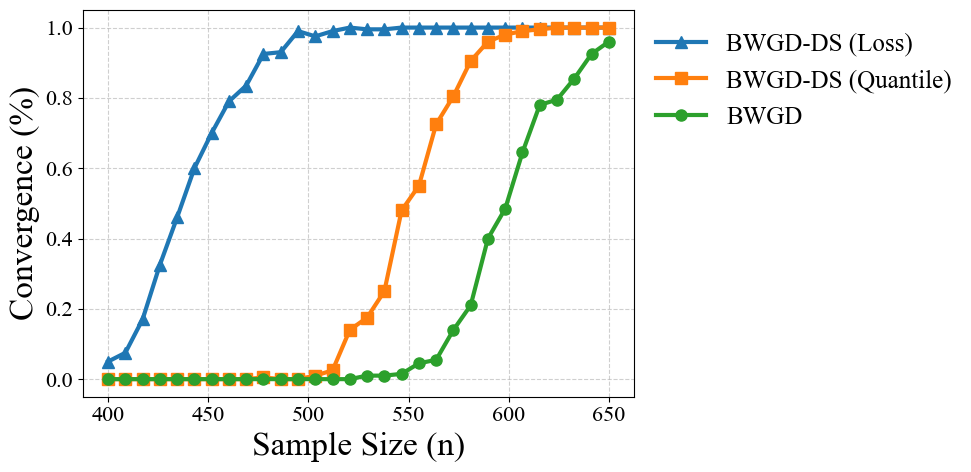

In [280]:
ns = np.linspace(400, 650, 30)
plt.figure(figsize=(10, 5))

# Plot with styling
plt.plot(ns, conv_spec2[2], label="BWGD-DS (Loss)", linewidth=3, marker='^')
plt.plot(ns, conv_spec2[1], label="BWGD-DS (Quantile)", linewidth=3, marker='s')
plt.plot(ns, conv_spec2[0], label="BWGD", linewidth=3, marker='o')

# Axis labels with font styling
plt.xlabel("Sample Size (n)", fontsize=24)
plt.ylabel("Convergence (%)", fontsize=24)

# Ticks and grid
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Make tick labels bigger. Y-Label Success Rate

In [175]:
ns = np.linspace(1000, 4000, 16)
conv_rand = convergence_percent(init="rand", ns=ns)
# change niter to 600?

100%|█████████████████████████████████████████████████████████████████████████████| 16/16 [35:40:59<00:00, 8028.72s/it]


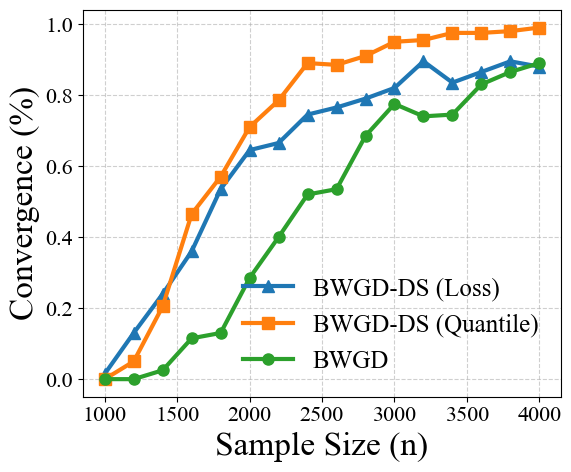

In [281]:
ns = np.linspace(1000, 4000, 16)
plt.figure(figsize=(6, 5))

# Plot with styling
plt.plot(ns, conv_rand[2], label="BWGD-DS (Loss)", linewidth=3, marker='^')
plt.plot(ns, conv_rand[1], label="BWGD-DS (Quantile)", linewidth=3, marker='s')
plt.plot(ns, conv_rand[0], label="BWGD", linewidth=3, marker='o')

# Axis labels with font styling
plt.xlabel("Sample Size (n)", fontsize=24)
plt.ylabel("Convergence (%)", fontsize=24)

# Ticks and grid
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(loc='best', frameon=False)
plt.tight_layout()
plt.show()

# More iterations Quantile (600), loss(6000?)

In [185]:
ns = np.linspace(400, 700, 21)
conv_heavy = convergence_percent(init="spec2", ns=ns, heavy_tail=True)

100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [4:25:23<00:00, 758.25s/it]


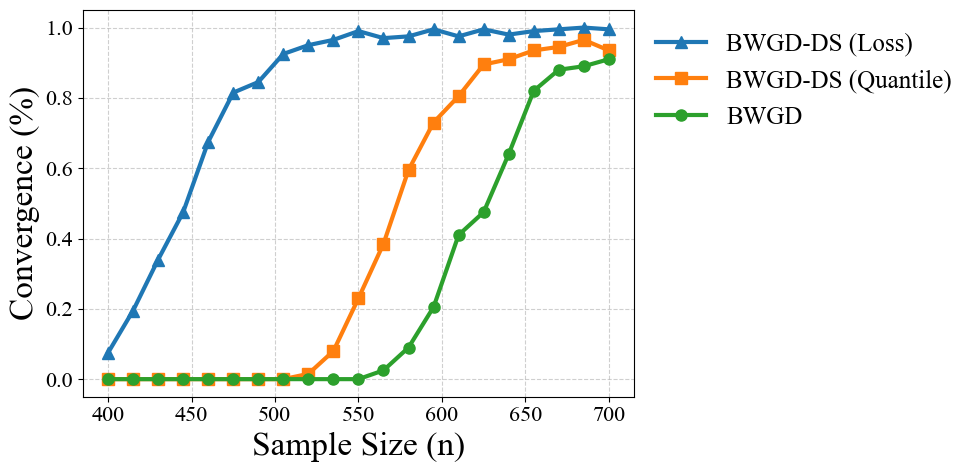

In [289]:
ns = np.linspace(400, 700, 21)
plt.figure(figsize=(10, 5))

# Plot with styling
plt.plot(ns, conv_heavy[2], label="BWGD-DS (Loss)", linewidth=3, marker='^')
plt.plot(ns, conv_heavy[1], label="BWGD-DS (Quantile)", linewidth=3, marker='s')
plt.plot(ns, conv_heavy[0], label="BWGD", linewidth=3, marker='o')

# Axis labels with font styling
plt.xlabel("Sample Size (n)", fontsize=24)
plt.ylabel("Convergence (%)", fontsize=24)

# Ticks and grid
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Try with Cauchy

Plot number of iterations until convergence (examples where it does converge) (spec2 only)
x-axis: sample size, y-axis: iter until convergence (log scale) 

In [167]:
def convergence_iterations(init, ns, niter=60, trials=50):
    d = 200
    its_regular = []
    its_smooth = []
    its_smoothl = []
    
    for n in tqdm(ns):
        n = int(n)
        reg_iters = []
        smooth_iters = []
        smoothl_iters = []

        for _ in range(trials):  
            x = np.ones(d) / np.sqrt(d)
            A = np.random.randn(d, n)
            y1 = np.square(A.T @ x)
            y2 = np.abs(A.T @ x)
            
            # Run the algorithm
            x_hat1, iters1 = bwgd(y1, A, init=init, niter=niter)
            x_hat2, iters2 = bwgd_smooth(y2, A, init=init, niter=niter)
            x_hat3, iters3 = bwgd_smooth_loss(y2, A, init=init, niter=3000)

            # Append only if convergence
            if min_error(x_hat1, x)[-1] < 1e-9:
                reg_iters.append(iters1)
            if min_error(x_hat2, x)[-1] < 1e-9:
                smooth_iters.append(iters2)
            if min_error(x_hat3, x)[-1] < 1e-9:
                smoothl_iters.append(iters3)
        
        # Average iteration count for each n (only converged cases)
        its_regular.append(np.mean(reg_iters) if reg_iters else np.nan)
        its_smooth.append(np.mean(smooth_iters) if smooth_iters else np.nan)
        its_smoothl.append(np.mean(smoothl_iters) if smoothl_iters else np.nan)

    return [its_regular, its_smooth, its_smoothl]
    
ns = np.linspace(500, 700, 31)
iters_spec2 = convergence_iterations(init="spec2", ns=ns)

100%|███████████████████████████████████████████████████████████████████████████████| 31/31 [1:56:49<00:00, 226.12s/it]


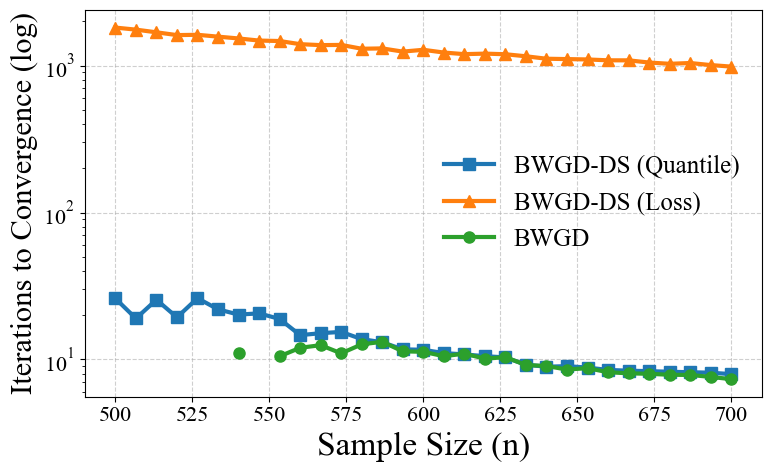

In [288]:
ns = np.linspace(500, 700, 31)

plt.figure(figsize=(8, 5))

# Plot with styling
plt.plot(ns, iters_spec2[1], label="BWGD-DS (Quantile)", linewidth=3, marker='s')
plt.plot(ns, iters_spec2[2], label="BWGD-DS (Loss)", linewidth=3, marker='^')
plt.plot(ns, iters_spec2[0], label="BWGD", linewidth=3, marker='o')


# Axis labels with font styling
plt.xlabel("Sample Size (n)", fontsize=24)
plt.ylabel("Iterations to Convergence (log)", fontsize=22)
plt.yscale('log')  


# Ticks and grid
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(loc='best', frameon=False)
plt.tight_layout()
plt.show()

Convergence time plots
Figure 1: Theoretical (spec2 and random) + Slice at max sample size (show superlinear)
Figure 2: Faster less stable methods (spec2 and random)
Figure 3: Heavy tailed (3 methods under spec2)

In [235]:
def convergence_time(bwgd, init, samples, max_iter=60,  num_trials=50, square=False, heavy_tail=False):
    d = 200                      
    
    # Initialize array: rows = iterations, cols = different sample sizes
    error_matrix = np.zeros((max_iter, len(samples)))
    
    for i, n in tqdm(enumerate(samples)):
        n = int(n)
        error_accumulator = np.zeros((max_iter,))
        error_accumulator_no_conv = np.zeros((max_iter,))
        converged_runs = 0
    
        for trial in range(num_trials):
            # Generate ground truth and data
            x = np.ones(d) / np.sqrt(d)
            if heavy_tail:
                A = np.random.standard_t(5, (d, n))
            else:
                A = np.random.randn(d, n)

            if square:
                y = np.square(A.T @ x)
            else:
                y = np.abs(A.T @ x)
    
            # Run the algorithm
            x_hat, iter_history = bwgd(y, A, init=init, niter=max_iter)
    
            # Compute errors at each iteration
            errors = min_error(x_hat, x)
            errors = np.array(errors)

            # Pad with NaNs or extend with final error value
            if len(errors) < max_iter:
                errors = np.concatenate([errors, np.full(max_iter - len(errors), errors[-1])])
            
            # Check for convergence
            if errors[-1] < 1e-8:
                error_accumulator += errors
                converged_runs += 1
            else:
                error_accumulator_no_conv += errors                
    
        # Average over converged runs
        if converged_runs > 0:
            error_matrix[:, i] = error_accumulator / converged_runs
        else:
            error_matrix[:, i] = error_accumulator_no_conv / num_trials

    return error_matrix

def plot_conv_time(matrix, samples, max_iter):
    plt.imshow(np.log10(matrix.T), 
                       aspect='auto',
                       origin='lower',
                       extent=[0, max_iter, samples[0], samples[-1]],
                       cmap='viridis')
    plt.xlabel("Iterations")
    plt.ylabel("Sample Size (n)")
    plt.colorbar()
    plt.show()

In [ ]:
Convergence time plots
Figure 1: Theoretical (spec2 and random) + Slice at max sample size (show superlinear)
Figure 2: Faster less stable methods (spec2 and random)
Figure 3: Heavy tailed (3 methods under spec2)

In [236]:
# Theoretical spec2
samples = np.linspace(350, 550, 16)
max_iter = 3000   
bsl_spec2 = convergence_time(bwgd_smooth_loss, init="spec2", samples=samples, max_iter=max_iter)

16it [59:54, 224.67s/it]


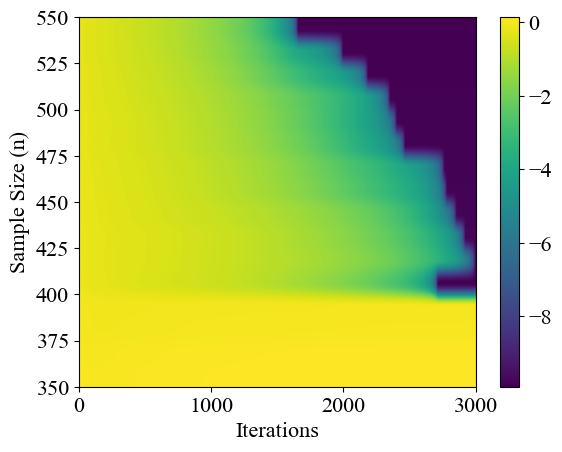

In [237]:
samples = np.linspace(350, 550, 16)
max_iter = 3000  
plot_conv_time(bsl_spec2, samples, max_iter)

In [238]:
# Theoretical rand
samples = np.linspace(1000, 2500, 16)
max_iter = 3000
bsl_rand = convergence_time(bwgd_smooth_loss, init="rand", samples=samples, max_iter=max_iter)

16it [5:41:54, 1282.15s/it]


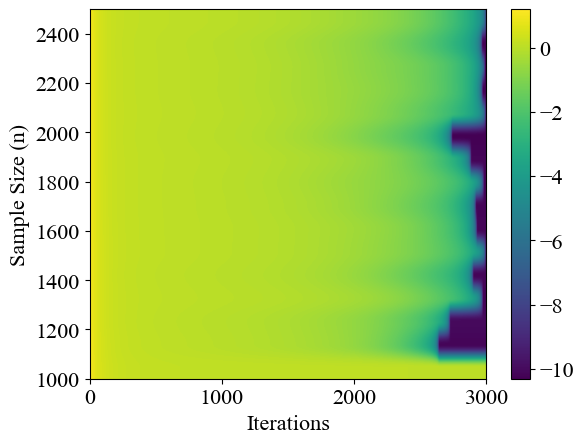

In [239]:
samples = np.linspace(1000, 2500, 16)
max_iter = 3000
plot_conv_time(bsl_rand, samples, max_iter)

# Geometric Mean over everything. average log error (average before log)

In [246]:
# Fast Methods spec2
samples = np.linspace(450, 650, 16)
max_iter = 3000                          
bs_spec2 = convergence_time(bwgd_smooth, init="spec2", samples=samples, max_iter=max_iter)
b_spec2 = convergence_time(bwgd, init="spec2", samples=samples, max_iter=max_iter, square=True)

16it [15:27, 57.97s/it]
16it [01:51,  6.99s/it]


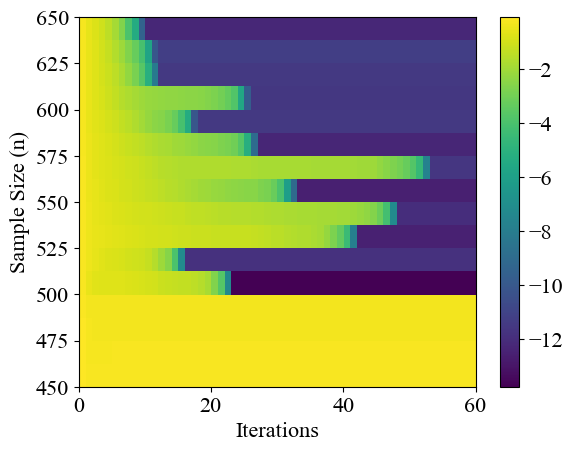

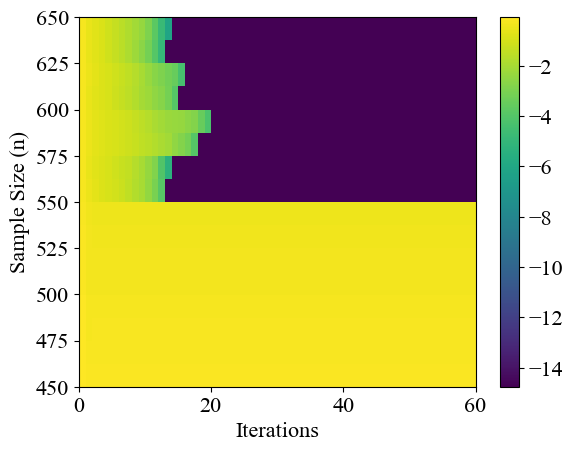

In [290]:
samples = np.linspace(450, 650, 16)
max_iter = 60        
plot_conv_time(bs_spec2[:max_iter], samples, max_iter)
plot_conv_time(b_spec2[:max_iter], samples, max_iter)

In [269]:
# Fast Methods rand
samples = np.linspace(500, 2500, 16)
max_iter = 3000                          
bs_rand = convergence_time(bwgd_smooth, init="rand", samples=samples, max_iter=max_iter)
b_rand = convergence_time(bwgd, init="rand", samples=samples, max_iter=max_iter, square=True)

16it [1:43:28, 388.01s/it]
16it [03:36, 13.53s/it]


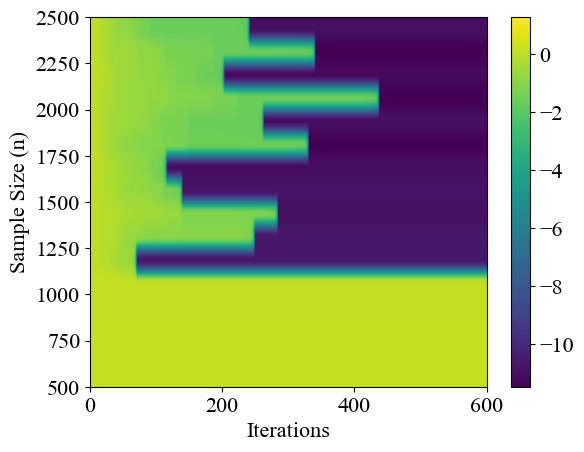

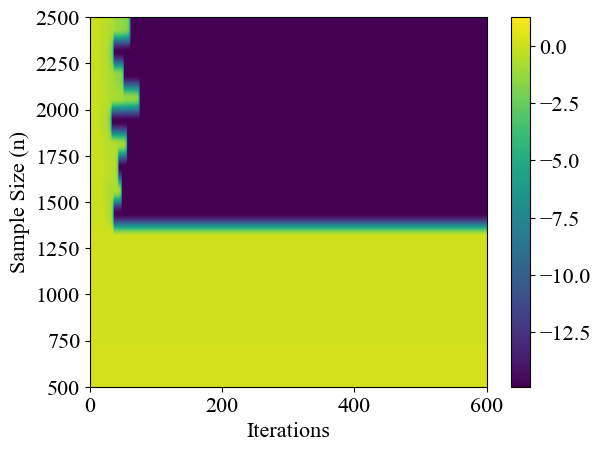

In [287]:
samples = np.linspace(500, 2500, 16)
max_iter = 600     
plot_conv_time(bs_rand[:max_iter], samples, max_iter)
plot_conv_time(b_rand[:max_iter], samples, max_iter)

In [254]:
# Heavy tail, 3 methods
samples = np.linspace(450, 650, 16)
max_iter = 3000                          
h_bs = convergence_time(bwgd_smooth, init="spec2", samples=samples, max_iter=max_iter, heavy_tail=True)
h_b = convergence_time(bwgd, init="spec2", samples=samples, max_iter=max_iter, square=True, heavy_tail=True)

16it [22:48, 85.54s/it]
16it [01:57,  7.33s/it]


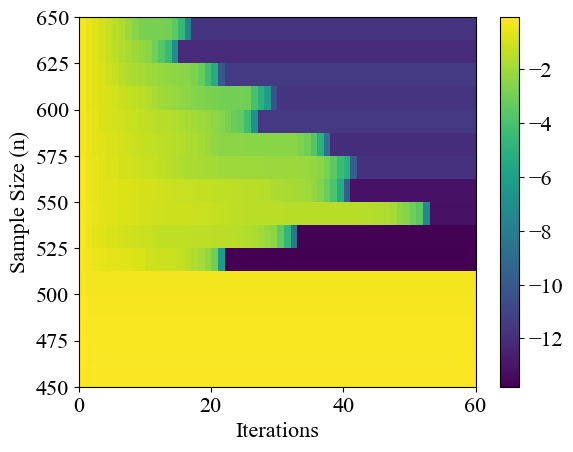

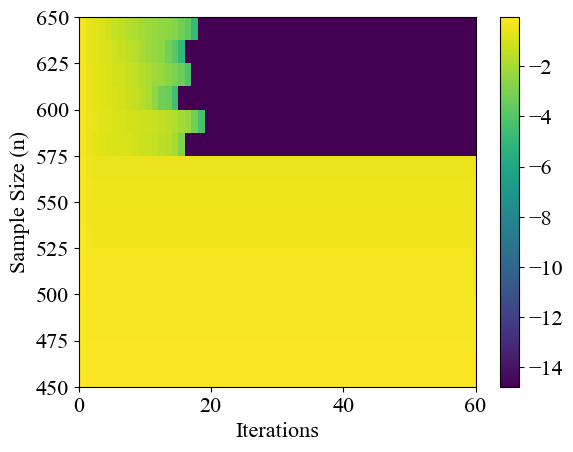

In [291]:
samples = np.linspace(450, 650, 16)
max_iter = 60  
plot_conv_time(h_bs[:max_iter], samples, max_iter)
plot_conv_time(h_b[:max_iter], samples, max_iter)

In [264]:
samples = np.linspace(350, 650, 16)
max_iter = 3000 
h_bsl = convergence_time(bwgd_smooth_loss, init="spec2", samples=samples, max_iter=max_iter, heavy_tail=True)

16it [48:12, 180.81s/it]


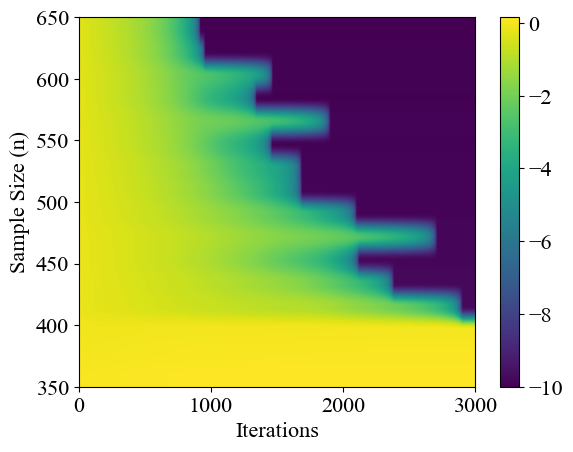

In [265]:
samples = np.linspace(350, 650, 16)
max_iter = 3000 
plot_conv_time(h_bsl, samples, max_iter)

Slice at max sample size (show superlinear)

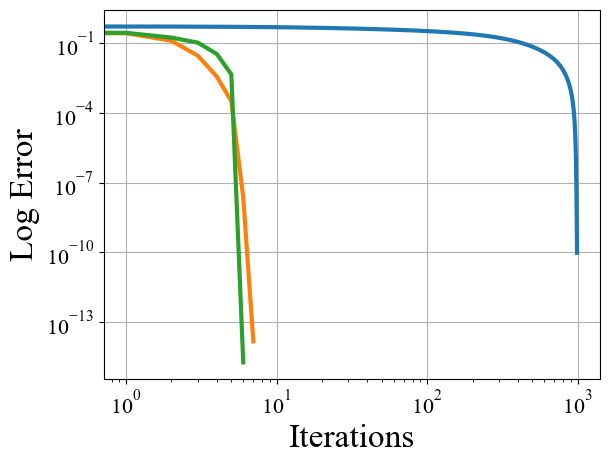

In [295]:
d=200
n=650
# Generate ground truth and data
x = np.ones(d) / np.sqrt(d)
A = np.random.randn(d, n)
y = np.abs(A.T @ x)
y2 = np.abs(A.T @ x)**2
    
# Run the algorithm
x_hat, iter_history = bwgd_smooth_loss(y, A, init="spec2",niter=4000)
x_hat2, iter_history = bwgd_smooth(y, A, init="spec2",niter=600)
x_hat3, iter_history = bwgd(y2, A, init="spec2",niter=600)


error = min_error(x_hat, x)
error2 = min_error(x_hat2, x)
error3 = min_error(x_hat3, x)

plt.plot(error, linewidth=3, label="")
plt.plot(error2, linewidth=3, label=)
plt.plot(error3, linewidth=3, label=)
plt.xlabel("Iterations", fontsize=24)
plt.ylabel("Log Error", fontsize=24)
plt.yscale('log')  
plt.xscale("log")
plt.grid(True)
plt.show()

# Add the labels

In [293]:
print(error2)

[0.7756530995271713, 0.567332736338384, 0.5744376327631253, 0.5860036856742775, 0.5876045460844012, 0.5853153907811388, 0.5802503516274834, 0.5788642001884763, 0.5796139517882359, 0.5807323846875582, 0.5812973063228162, 0.5813448633684114, 0.5816028060313659, 0.5817105414293358, 0.5817509741062274, 0.581966662985936, 0.5836277015106622, 0.5836249962443597, 0.5835474829587778, 0.5835545167025005, 0.5835572408267445, 0.5835556585075351, 0.5835547606398976, 0.5835545617964795, 0.5835545303669829, 0.583554519613307, 0.5835545148756761, 0.5835545135843723, 0.583554513408744, 0.5835545134186435, 0.5835545134349424, 0.5835545134448434, 0.5835545134502222]
